In [ ]:
# Load .csv files and format the events to save them as .npy files and load them easily

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from aprovhots import csv2npy, get_info
path = '/home/INT/grimaldi.a/Documents/projets/WP3/2021-12-06_simulator_data/'
list_npy = csv2npy(path)

list of all .csv files : 
 ['only_sea_session_2.csv', 'only_sea_session_1.csv', 'mixed_session_1.csv', 'only_sea_session_3.csv', 'mixed_session_3.csv', 'mixed_session_2.csv', 'only_ground_session_1.csv'] 

only_sea_session_2.csv was already loaded saved as .npy file
only_sea_session_1.csv was already loaded saved as .npy file
mixed_session_1.csv was already loaded saved as .npy file
only_sea_session_3.csv was already loaded saved as .npy file
mixed_session_3.csv was already loaded saved as .npy file
mixed_session_2.csv was already loaded saved as .npy file
only_ground_session_1.csv was already loaded saved as .npy file


# Open the .npy files and get some information

In [21]:
density = get_info(path, list_npy)

file name: only_sea_session_2.npy
recording duration: 1328.0 s 
 events density: 10873.698 ev/sec 
 number of ON/OFF events: 0.999

file name: only_sea_session_1.npy
recording duration: 16.0 s 
 events density: 5954.397 ev/sec 
 number of ON/OFF events: 0.779

file name: mixed_session_1.npy
recording duration: 93.0 s 
 events density: 8614.034 ev/sec 
 number of ON/OFF events: 1.013

file name: only_sea_session_3.npy
recording duration: 691.0 s 
 events density: 13764.88 ev/sec 
 number of ON/OFF events: 0.999

file name: mixed_session_3.npy
recording duration: 705.0 s 
 events density: 13822.538 ev/sec 
 number of ON/OFF events: 0.897

file name: mixed_session_2.npy
recording duration: 323.0 s 
 events density: 7418.496 ev/sec 
 number of ON/OFF events: 0.953

file name: only_ground_session_1.npy
recording duration: 636.0 s 
 events density: 39175.777 ev/sec 
 number of ON/OFF events: 1.003



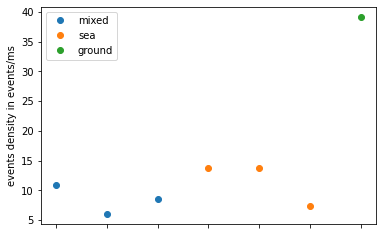

In [22]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.plot(np.arange(3),density[:3], 'o', label = 'mixed')
ax.plot(np.arange(3,6), density[3:6], 'o', label = 'sea')
ax.plot([6], density[6:], 'o', label = 'ground')
ax.set_ylabel('events density in events/ms');
ax.set_xticklabels([]);
plt.legend()

In [37]:
fig.savefig('event_density.pdf')